In [2]:
from langfuse import get_client
import json
from dotenv import load_dotenv
from datetime import datetime, timezone

load_dotenv()  # Load environment variables from .env file


True

In [3]:
import time
import random
try:
    from langfuse import ApiError
except ImportError:
    # Fallback - try different import paths
    try:
        from langfuse.client import ApiError  
    except ImportError:
        print("ApiError not found, mocking")
        # Create a generic exception class if we can't find the right one
        class ApiError(Exception):
            def __init__(self, status_code, body):
                self.status_code = status_code
                self.body = body
                super().__init__(f"API Error {status_code}: {body}")

ApiError not found, mocking


In [4]:
def fetch_trace_with_retry(langfuse_client, trace_id, max_retries=3, base_delay=1.0):
    """Fetch trace with exponential backoff retry logic"""
    for attempt in range(max_retries):
        try:
            return langfuse_client.api.trace.get(trace_id)
        except Exception as e:
            # Check if it's a rate limit error (429)
            is_rate_limit = False
            if hasattr(e, 'status_code') and e.status_code == 429:
                is_rate_limit = True
            elif 'rate limit' in str(e).lower() or '429' in str(e):
                is_rate_limit = True
                
            if is_rate_limit:
                if attempt < max_retries - 1:
                    # Exponential backoff with jitter
                    delay = (base_delay * (2 ** attempt)) + random.uniform(0, 1)
                    print(f"Rate limited, retrying in {delay:.2f}s (attempt {attempt + 1}/{max_retries})",end='\r')
                    time.sleep(delay)
                    continue
                else:
                    print(f"Max retries exceeded for trace {trace_id}")
                    return None
            else:
                # Re-raise non-rate-limit errors immediately
                print(f"Non-rate-limit error for trace {trace_id}: {str(e)}")
                raise
    return None

In [5]:
langfuse = get_client()
if langfuse.auth_check():
    print("Successfully authenticated with Langfuse.")
else:
    print("Failed to authenticate with Langfuse. Please check your API key and connection.")


Successfully authenticated with Langfuse.


In [6]:

start_time = datetime.fromisoformat("2026-02-03T14:00:17.137054+00:00")
end_time = datetime.fromisoformat("2026-02-10T07:46:32.934946+00:00")

all_traces = []
found = False
page = 7
limit_per_page = 100

In [7]:
print("Fetching traces...")
while True:
    # Fetch traces with pagination
    traces_response = langfuse.api.trace.list(limit=limit_per_page, page=page)
    
    if not traces_response.data:
        break
        
    # Filter traces by date range
    filtered_traces = [
        trace for trace in traces_response.data
        if start_time <= datetime.fromisoformat(trace.createdAt) <= end_time
    ]
    if filtered_traces:
        found = True
    
    all_traces.extend(filtered_traces)
    print(f"Page {page}: Found {len(filtered_traces)} traces in date range ({len(traces_response.data)} total on page)")
    
    if found and len(filtered_traces) == 0:
        break
        
    page += 1


if len(all_traces) == 0:
    print(f"No traces found in Langfuse between {start_time} and {end_time}. Please check the date range and try again.")
else:
    print(f"Total traces found in date range: {len(all_traces)}")

Fetching traces...
Page 7: Found 0 traces in date range (100 total on page)
Page 8: Found 0 traces in date range (100 total on page)
Page 9: Found 0 traces in date range (100 total on page)
Page 10: Found 0 traces in date range (100 total on page)
Page 11: Found 35 traces in date range (100 total on page)
Page 12: Found 100 traces in date range (100 total on page)
Page 13: Found 100 traces in date range (100 total on page)
Page 14: Found 100 traces in date range (100 total on page)
Page 15: Found 100 traces in date range (100 total on page)
Page 16: Found 100 traces in date range (100 total on page)
Page 17: Found 100 traces in date range (100 total on page)
Page 18: Found 100 traces in date range (100 total on page)
Page 19: Found 100 traces in date range (100 total on page)
Page 20: Found 98 traces in date range (100 total on page)
Page 21: Found 0 traces in date range (100 total on page)
Total traces found in date range: 933


In [9]:
results = []
att_error_count = 0
failed_fetches = 0
models = set()
frameworks = set()

print(f"Processing {len(all_traces)} traces with rate limiting...")

for idx, trace in enumerate(all_traces):
    # Add delay between requests to avoid rate limits
    if idx > 0 and idx % 5 == 0:  # Every 10 requests
        time.sleep(0.4)  # Small delay to be respectful to API
        
    full_trace = fetch_trace_with_retry(langfuse, trace.id, max_retries=3)
    
    if full_trace is None:
        failed_fetches += 1
        continue
        
    metadata = trace.metadata
    model = metadata.get('model')
    framework = metadata.get('framework')
    if model:
        models.add(model)
    if framework:
        frameworks.add(framework)
    tool_calls_v1 = [obs.output.get("tool_calls") for obs in full_trace.observations 
                          if type(obs.output)== dict and obs.output.get("tool_calls")]
    tool_calls_v2 = [obs.output[0].get("tool_calls") for obs in full_trace.observations 
                          if type(obs.output)== list and obs.output and type(obs.output[0])== dict and obs.output[0].get("tool_calls")]
    
    tool_calls = len([call for call in tool_calls_v1 if call]) + len([call for call in tool_calls_v2 if call])
    

    results.append({
        'task_id': trace.id,
        'model': model,
        'framework': framework,
        'tool_calls': tool_calls
    })
    
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{len(all_traces)} traces, with {att_error_count + failed_fetches} issues...")

print(f"Total traces processed: {len(all_traces)}")
print(f"Traces with attribute errors: {att_error_count}")
print(f"Failed fetches: {failed_fetches}")

Processing 933 traces with rate limiting...
Max retries exceeded for trace 0ca9d6ca67e05f95347852f4681eb67e
Max retries exceeded for trace 9ff1fdbd44f86036a9c85d1fcd0d0c96
Max retries exceeded for trace 50c3a6b1cf93bc5e4f2c3e1f2f78c116
Max retries exceeded for trace 3e30b6630b4e89a8a99fd0829040257c
Max retries exceeded for trace b9d853348f42f6038cfc7626d8518750
Max retries exceeded for trace ce19330faae5b9093a1f0fc4f9834fa0
Max retries exceeded for trace 11c64cf91563eb5d5d86bcbbc490e5fa
Max retries exceeded for trace 2202d584cb6b1e7732537be4afe668d9
Max retries exceeded for trace 65a1827c7b5f573b314cb44c53c42e06
Max retries exceeded for trace 8dbf996e017d7672b4253a8a66e9d248
Processed 50/933 traces, with 10 issues.../3)
Max retries exceeded for trace 8128fac32565727b008ca2777a2862f4
Max retries exceeded for trace fcb596d7c6eb47ae308044adbd35fb2a
Max retries exceeded for trace 2cf3c6222ba0784a245174b7193a14d2
Max retries exceeded for trace 5a8f1a00611403af6b4ef8f50528671e
Max retries ex

In [10]:
frameworks.discard(None)
frameworks.discard("crewai")
frameworks.discard("langchain")
agents = [f"{model} X {framework}" for model in models for framework in frameworks]
none_count = 0
analysed = {agent: 0 for agent in agents}
tool_calls = {agent: 0 for agent in agents}
for result in results:
    print( result)
    if result["framework"] in ["crewai","langchain"]:
        continue
    if not (result['model'] and result['framework']):
        none_count += 1
        print(f"Skipping for the {none_count} time due to missing model or framework: {result}")
        continue
    agent = f"{result['model']} X {result['framework']}"
    analysed[agent] += 1
    tool_calls[agent] += result['tool_calls']
average_tool_calls = {agent: (tool_calls[agent] / analysed[agent] if analysed[agent] > 0 else 0) for agent in agents}
for agent in agents:
    print(f"{agent}: Analysed {analysed[agent]} traces, Total Tool Calls: {tool_calls[agent]}, average tool calls per trace: {average_tool_calls[agent] :.2f}")
        

{'task_id': '071562b253a05a452f5a5c777658de27', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 6}
{'task_id': 'd715e85d68c16d98fa1e1d510383f537', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 25}
{'task_id': 'a35c58f7d6cb6c48f7f3168af140b182', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 7}
{'task_id': '30a702b41011e3d1fb19fca992ec3a9b', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 0}
{'task_id': '52d16429a86a175de1b27567da1020a7', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 11}
{'task_id': 'af14b683d64d42fb364955fe77aafad7', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 9}
{'task_id': '08f7715b79cc0cf816082e16fb13ca90', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 0}
{'task_id': 'fbdb7dcf156a9dc4c5e3f184173b37d5', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 0}
{'task_id': '1d536bf38dbe33033544319a8126349b', 'model': 'gpt-oss-120b

gpt-oss-20b X openai_agents: 10.64
gpt-oss-20b X langgraph: 7.66
gpt-oss-120b X openai_agents: 10.81
gpt-oss-120b X langgraph: 6.67
Meta-Llama-3_3-70B-Instruct X openai_agents: 0.38
Meta-Llama-3_3-70B-Instruct X langgraph: 1.76
Mistral-Small-3.2-24B-Instruct-2506 X openai_agents: 1.84
Mistral-Small-3.2-24B-Instruct-2506 X langgraph: 2.68


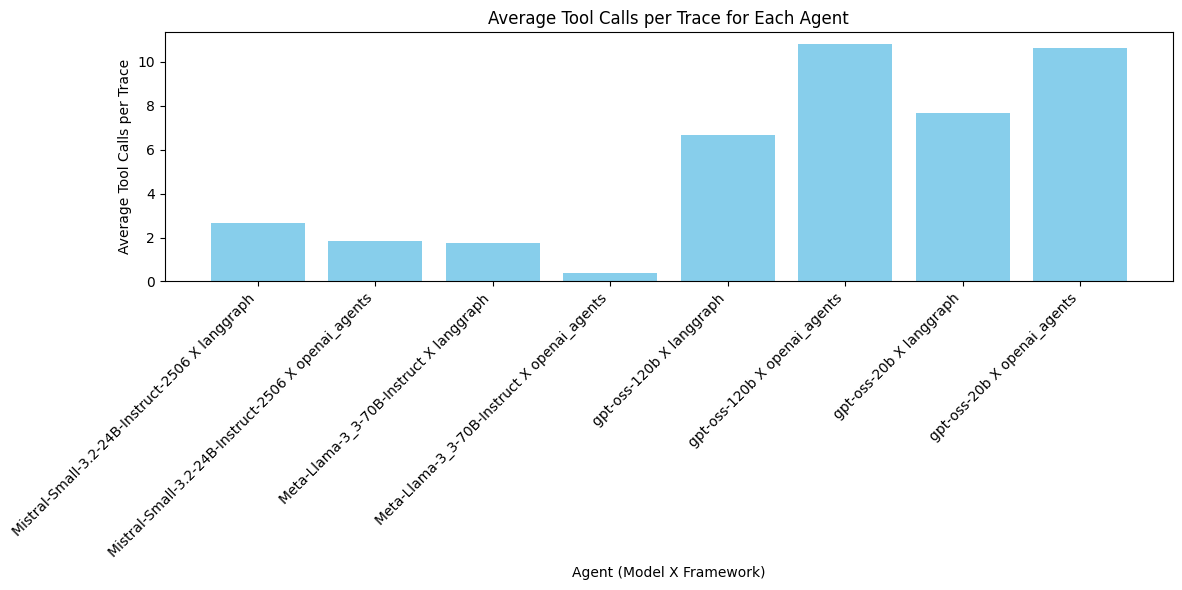

In [ ]:
for agent, avg_calls in average_tool_calls.items():
    print(f"{agent}: {avg_calls:.2f}")
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
plt.bar(average_tool_calls.keys(), average_tool_calls.values(), color='skyblue')
plt.xlabel('Agent (Model X Framework)')
plt.ylabel('Average Tool Calls per Trace')
plt.title('Average Tool Calls per Trace for Each Agent')
plt.xticks(rotation=45, ha='right')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()